# 搭建神经网络完成图像识别任务（数据集：CIFAR-10）

### 数据集介绍

CIFAR-10数据集包含10个类别的60000张32x32彩色图像，每个类别有6000张图像。数据集分为50000张训练图像和10000张测试图像。

In [1]:
n_class=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship"]

### 数据集下载与展示

In [2]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import numpy as np
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

print(f"prepare preprocessing, CIFAR-10")
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]) # meanstd transformation

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

prepare preprocessing, CIFAR-10


In [4]:
print("| Preparing CIFAR-10 dataset...")

trainset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=True, download=False, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=False, download=False, transform=transform_test)
num_classes = 10

| Preparing CIFAR-10 dataset...


## 展示测试集的前几张图片

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


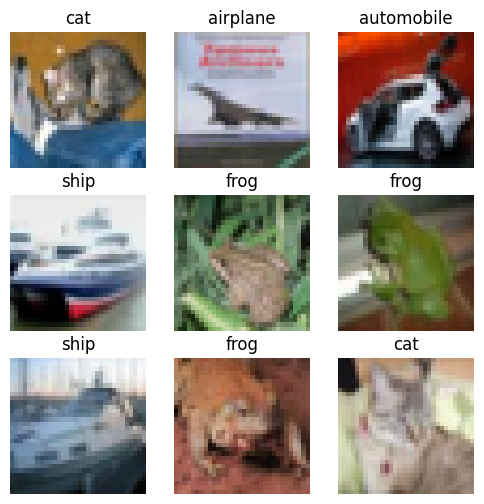

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def unnormalize(img):
    for channel, mean, std in zip(img, [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]):
        channel.mul_(std).add_(mean)  
    return img

n_class=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

fig, axs = plt.subplots(3,3,figsize=(6, 6))
for i in range (9):
    ax=axs[i%3,i//3]
    data, label= testset[i]
    image=unnormalize(data)
    npimg = image.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))

    ax.imshow(npimg)
    ax.axis('off')
    ax.set_title(n_class[label])

plt.show()

### 神经网络模型搭建

#### a large scale of neural neworks ： MLPs，VGG，ResNet，Vision Transformer， 我们这里以VGG16 卷积神经网络为例

In [7]:
import torch
import torch.nn as nn
from collections import  OrderedDict

cfg = {
    #'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG16_0.5': [32, 32, 'M', 64, 64, 'M', 128, 128, 128, 'M', 256, 256, 256, 'M', 256, 256, 256, 'M'],
    'VGG16_1.5': [96, 96, 'M', 192, 192, 'M', 384, 384, 384, 'M', 768, 768, 768, 'M', 768, 768, 768, 'M'],
    
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'VGG19_0.5': [32, 32, 'M', 64,64, 'M', 128, 128, 128, 128, 'M', 256, 256, 256, 256, 'M', 256, 256, 256, 256, 'M'],
    'VGG19_1.5': [96, 96, 'M', 192,192, 'M', 384, 384, 384, 384, 'M', 768, 768, 768, 768, 'M', 768, 768, 768, 768, 'M']
}


class VGG_cifar(nn.Module):
    def __init__(self, depth, num_classes, width_factor=1):
        super(VGG_cifar, self).__init__()
        if abs(width_factor - 1) > 1e-4:
            print(f"Initialize the VGG by width factor: {width_factor}")
            self.features = self._make_layers(cfg[f'VGG{depth}_{width_factor}'])
            linear_input = int(round(512 * width_factor))
        else:
            print(f"Initialize the VGG by default width factor 1")
            self.features = self._make_layers(cfg[f'VGG{depth}'])
            linear_input = 512

        self.linear = nn.Linear(linear_input, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        i=0
        for x in cfg:
            i=i+1
            if x == 'M':
                layers.append(('MaxPool2d_{}'.format(i),nn.MaxPool2d(kernel_size=2, stride=2)))
            else:
                layers.append(('conv_{}'.format(i),nn.Conv2d(in_channels, x, kernel_size=3, padding=1)))
                layers.append(('bn_{}'.format(i),nn.BatchNorm2d(x)))
                layers.append(('relu_{}'.format(i), nn.ReLU(inplace=True)))
                in_channels = x
        layers.append(('AvgPool2d_{}'.format(i),nn.AvgPool2d(kernel_size=1, stride=1)))
        return nn.Sequential(OrderedDict(layers))


In [8]:
net=net = VGG_cifar(16,10, 1)
#net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
net = torch.nn.DataParallel(net, device_ids=[0])
net.cuda()
cudnn.benchmark = True


Initialize the VGG by default width factor 1


### 定义训练函数

In [9]:
def train(epoch, net, num_epochs, trainloader, criterion, optimizer, writer):
    net.train()
    net.training = True
    train_loss = 0
    correct = 0
    total = 0 

    print(f'Training Epoch {epoch}')
    pbar = tqdm.tqdm(total=len(trainloader), desc="Training")

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda() # GPU settings
        optimizer.zero_grad()
        outputs = net(inputs)               # Forward Propagation
        loss = criterion(outputs, targets)  # Loss
        
        loss.backward()                     # Backward Propagation
            
        optimizer.step()                    # Optimizer update

        train_loss += loss.item() * targets.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        pbar.update(1)
       
    pbar.close()
    train_loss /= total
    acc = 100.*correct/total
    acc = acc.item()

    writer.add_scalar('Train Loss /epoch', train_loss, epoch)
    writer.add_scalar('Train Acc /epoch', acc, epoch)

    return acc, train_loss


### 定义测试函数

In [10]:
def test(epoch, net, testloader, criterion, writer):
    net.eval()
    net.training = False
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * targets.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        # Save checkpoint when best model
        acc = 100.*correct/total
        acc = acc.item()
        test_loss = test_loss/total
    writer.add_scalar('Test Loss /epoch', test_loss, epoch)
    writer.add_scalar('Test Acc /epoch', acc, epoch)
        
        
    return acc, test_loss

def test_(epoch, net, testloader, criterion):
    net.eval()
    net.training = False
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * targets.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        # Save checkpoint when best model
        acc = 100.*correct/total
        acc = acc.item()
        test_loss = test_loss/total

        
        
    return acc, test_loss

### 定义损失函数


In [11]:
criterion = nn.CrossEntropyLoss().cuda()

### 定义优化器


In [12]:
optimizer=torch.optim.SGD(net.parameters(),lr=0.1,momentum=0.9,weight_decay=5e-4)

### 定义学习率 

In [13]:
def cosine_decay(init, epoch, total_epoch, warmup_epochs=0):
    epoch = min(epoch, total_epoch)
    cosine_decay = 0.5 * (1 + math.cos(np.pi * epoch / total_epoch))
    
    return init * cosine_decay

# 开始训练

### 创建存储数据和模型的路径

In [14]:
from pathlib import Path
from os.path import join
ckpt_path='/home/tpang2000/AI_with_math/cifar10_lr0.1_vgg16_sgd'

Path(ckpt_path).mkdir(parents=True, exist_ok=True)


### 数据集分组

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=6)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)


### 测试一下未开始训练的模型性能

In [16]:
test_acc, test_loss = test_(epoch=0, net=net, testloader=testloader, criterion=criterion)
print(f"Epoch 0: Test Acc: {test_acc:.3f}, Test Loss: {test_loss:.3f}")


Epoch 0: Test Acc: 10.000, Test Loss: 2.303


In [17]:
## 正式训练

In [18]:
import time
import tqdm
import math

def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s

writer = SummaryWriter('./summaries/cifar10_lr0.1_vgg16_sgd')
elapsed_time = 0
best_acc=0
start_epoch=1
num_epochs=100
training_stats = \
{'test_acc': [test_acc],
'test_loss': [test_loss],
'train_acc': [],
'train_loss': [],
'current_lr':[],
'schedule_next_lr':[]
}

untuned_lr = 0.1
is_current_best=False
for epoch in range(start_epoch, start_epoch+num_epochs):
    epoch_start_time = time.time()

    # this is current LR
    current_lr = untuned_lr
    print(f"##############Epoch {epoch}  current LR: {current_lr:.5f}################")

    # train and test
    train_acc, train_loss = train(epoch, net, num_epochs, trainloader, criterion, optimizer, writer)
    print("\n| Train Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, train_loss, train_acc))
    test_acc, test_loss = test(epoch, net, testloader, criterion, writer)
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, test_loss, test_acc))

    # save best
    if test_acc > best_acc:
        print('| Saving Best model')
        state = {
            'net': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'test_acc':test_acc,
            'best_acc': best_acc,
            'test_loss':test_loss,
            'train_acc':train_acc,
            'train_loss':train_loss,
            'epoch':epoch
        }
        best_acc = test_acc
        is_current_best=True
        torch.save(state, join(ckpt_path, f'epoch_best.ckpt'))
    else:
        is_current_best=False

    untuned_lr = cosine_decay(0.1, epoch,num_epochs)
    print(f"------------>Rescheduled decayed LR: {untuned_lr:.5f}<--------------------")
    for param_group in optimizer.param_groups:
        param_group['lr'] = untuned_lr
    training_stats['test_acc'].append(test_acc)
    training_stats['test_loss'].append(test_loss)
    training_stats['train_acc'].append(train_acc)
    training_stats['train_loss'].append(train_loss)
    training_stats['current_lr'].append(current_lr)
    training_stats['schedule_next_lr'].append(untuned_lr)

    np.save(join(ckpt_path, "training_stats.npy"), training_stats)
    epoch_time = time.time() - epoch_start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d'  %(get_hms(elapsed_time)))
    print('--------------------> <--------------------')

writer.close()





##############Epoch 1  current LR: 0.10000################
Training Epoch 1


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.52it/s]


| Train Epoch #1			Loss: 2.4834 Acc@1: 12.50%



| Validation Epoch #1			Loss: 2.0706 Acc@1: 21.89%
| Saving Best model
------------>Rescheduled decayed LR: 0.09998<--------------------
| Elapsed time : 0:00:23
--------------------> <--------------------
##############Epoch 2  current LR: 0.09998################
Training Epoch 2


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.15it/s]


| Train Epoch #2			Loss: 1.9411 Acc@1: 22.63%



| Validation Epoch #2			Loss: 1.8153 Acc@1: 27.02%
| Saving Best model
------------>Rescheduled decayed LR: 0.09990<--------------------
| Elapsed time : 0:00:45
--------------------> <--------------------
##############Epoch 3  current LR: 0.09990################
Training Epoch 3


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.19it/s]


| Train Epoch #3			Loss: 1.7620 Acc@1: 30.22%



| Validation Epoch #3			Loss: 1.6819 Acc@1: 33.25%
| Saving Best model
------------>Rescheduled decayed LR: 0.09978<--------------------
| Elapsed time : 0:01:06
--------------------> <--------------------
##############Epoch 4  current LR: 0.09978################
Training Epoch 4


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.24it/s]


| Train Epoch #4			Loss: 1.5308 Acc@1: 41.05%



| Validation Epoch #4			Loss: 1.7372 Acc@1: 37.63%
| Saving Best model
------------>Rescheduled decayed LR: 0.09961<--------------------
| Elapsed time : 0:01:28
--------------------> <--------------------
##############Epoch 5  current LR: 0.09961################
Training Epoch 5


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.12it/s]


| Train Epoch #5			Loss: 1.3028 Acc@1: 52.23%



| Validation Epoch #5			Loss: 1.3670 Acc@1: 53.37%
| Saving Best model
------------>Rescheduled decayed LR: 0.09938<--------------------
| Elapsed time : 0:01:50
--------------------> <--------------------
##############Epoch 6  current LR: 0.09938################
Training Epoch 6


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.19it/s]


| Train Epoch #6			Loss: 1.0745 Acc@1: 62.29%



| Validation Epoch #6			Loss: 1.2224 Acc@1: 57.44%
| Saving Best model
------------>Rescheduled decayed LR: 0.09911<--------------------
| Elapsed time : 0:02:12
--------------------> <--------------------
##############Epoch 7  current LR: 0.09911################
Training Epoch 7


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.18it/s]



| Train Epoch #7			Loss: 0.9173 Acc@1: 68.27%

| Validation Epoch #7			Loss: 0.9347 Acc@1: 67.16%
| Saving Best model
------------>Rescheduled decayed LR: 0.09880<--------------------
| Elapsed time : 0:02:33
--------------------> <--------------------
##############Epoch 8  current LR: 0.09880################
Training Epoch 8


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.15it/s]


| Train Epoch #8			Loss: 0.8073 Acc@1: 72.80%



| Validation Epoch #8			Loss: 1.0361 Acc@1: 67.42%
| Saving Best model
------------>Rescheduled decayed LR: 0.09843<--------------------
| Elapsed time : 0:02:55
--------------------> <--------------------
##############Epoch 9  current LR: 0.09843################
Training Epoch 9


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.21it/s]


| Train Epoch #9			Loss: 0.7374 Acc@1: 75.21%



| Validation Epoch #9			Loss: 0.9093 Acc@1: 71.48%
| Saving Best model
------------>Rescheduled decayed LR: 0.09801<--------------------
| Elapsed time : 0:03:17
--------------------> <--------------------
##############Epoch 10  current LR: 0.09801################
Training Epoch 10


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.21it/s]


| Train Epoch #10			Loss: 0.6857 Acc@1: 77.14%



| Validation Epoch #10			Loss: 0.7161 Acc@1: 75.36%
| Saving Best model
------------>Rescheduled decayed LR: 0.09755<--------------------
| Elapsed time : 0:03:38
--------------------> <--------------------
##############Epoch 11  current LR: 0.09755################
Training Epoch 11


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.20it/s]


| Train Epoch #11			Loss: 0.6493 Acc@1: 78.60%



| Validation Epoch #11			Loss: 0.6919 Acc@1: 77.08%
| Saving Best model
------------>Rescheduled decayed LR: 0.09704<--------------------
| Elapsed time : 0:04:00
--------------------> <--------------------
##############Epoch 12  current LR: 0.09704################
Training Epoch 12


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.17it/s]


| Train Epoch #12			Loss: 0.6279 Acc@1: 79.26%



| Validation Epoch #12			Loss: 0.9006 Acc@1: 70.02%
------------>Rescheduled decayed LR: 0.09649<--------------------
| Elapsed time : 0:04:22
--------------------> <--------------------
##############Epoch 13  current LR: 0.09649################
Training Epoch 13


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.22it/s]


| Train Epoch #13			Loss: 0.5976 Acc@1: 80.33%



| Validation Epoch #13			Loss: 0.6755 Acc@1: 78.29%
| Saving Best model
------------>Rescheduled decayed LR: 0.09589<--------------------
| Elapsed time : 0:04:43
--------------------> <--------------------
##############Epoch 14  current LR: 0.09589################
Training Epoch 14


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.21it/s]


| Train Epoch #14			Loss: 0.5691 Acc@1: 81.17%



| Validation Epoch #14			Loss: 0.7774 Acc@1: 74.44%
------------>Rescheduled decayed LR: 0.09524<--------------------
| Elapsed time : 0:05:05
--------------------> <--------------------
##############Epoch 15  current LR: 0.09524################
Training Epoch 15


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.11it/s]


| Train Epoch #15			Loss: 0.5558 Acc@1: 81.67%



| Validation Epoch #15			Loss: 0.6024 Acc@1: 80.44%
| Saving Best model
------------>Rescheduled decayed LR: 0.09455<--------------------
| Elapsed time : 0:05:27
--------------------> <--------------------
##############Epoch 16  current LR: 0.09455################
Training Epoch 16


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.22it/s]


| Train Epoch #16			Loss: 0.5305 Acc@1: 82.48%



| Validation Epoch #16			Loss: 0.7075 Acc@1: 77.65%
------------>Rescheduled decayed LR: 0.09382<--------------------
| Elapsed time : 0:05:48
--------------------> <--------------------
##############Epoch 17  current LR: 0.09382################
Training Epoch 17


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.16it/s]


| Train Epoch #17			Loss: 0.5110 Acc@1: 83.10%



| Validation Epoch #17			Loss: 0.8596 Acc@1: 72.91%
------------>Rescheduled decayed LR: 0.09304<--------------------
| Elapsed time : 0:06:10
--------------------> <--------------------
##############Epoch 18  current LR: 0.09304################
Training Epoch 18


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.19it/s]


| Train Epoch #18			Loss: 0.5129 Acc@1: 83.05%



| Validation Epoch #18			Loss: 1.3324 Acc@1: 63.69%
------------>Rescheduled decayed LR: 0.09222<--------------------
| Elapsed time : 0:06:31
--------------------> <--------------------
##############Epoch 19  current LR: 0.09222################
Training Epoch 19


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.21it/s]


| Train Epoch #19			Loss: 0.5049 Acc@1: 83.30%



| Validation Epoch #19			Loss: 0.5940 Acc@1: 80.40%
------------>Rescheduled decayed LR: 0.09135<--------------------
| Elapsed time : 0:06:53
--------------------> <--------------------
##############Epoch 20  current LR: 0.09135################
Training Epoch 20


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.18it/s]


| Train Epoch #20			Loss: 0.4882 Acc@1: 83.88%



| Validation Epoch #20			Loss: 0.7562 Acc@1: 75.76%
------------>Rescheduled decayed LR: 0.09045<--------------------
| Elapsed time : 0:07:14
--------------------> <--------------------
##############Epoch 21  current LR: 0.09045################
Training Epoch 21


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.08it/s]


| Train Epoch #21			Loss: 0.4801 Acc@1: 84.23%



| Validation Epoch #21			Loss: 0.6247 Acc@1: 80.68%
| Saving Best model
------------>Rescheduled decayed LR: 0.08951<--------------------
| Elapsed time : 0:07:36
--------------------> <--------------------
##############Epoch 22  current LR: 0.08951################
Training Epoch 22


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.18it/s]


| Train Epoch #22			Loss: 0.4663 Acc@1: 84.55%



| Validation Epoch #22			Loss: 0.6122 Acc@1: 80.22%
------------>Rescheduled decayed LR: 0.08853<--------------------
| Elapsed time : 0:07:57
--------------------> <--------------------
##############Epoch 23  current LR: 0.08853################
Training Epoch 23


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.21it/s]


| Train Epoch #23			Loss: 0.4480 Acc@1: 85.13%



| Validation Epoch #23			Loss: 0.8515 Acc@1: 74.42%
------------>Rescheduled decayed LR: 0.08751<--------------------
| Elapsed time : 0:08:19
--------------------> <--------------------
##############Epoch 24  current LR: 0.08751################
Training Epoch 24


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.20it/s]


| Train Epoch #24			Loss: 0.4536 Acc@1: 85.25%



| Validation Epoch #24			Loss: 0.4916 Acc@1: 83.45%
| Saving Best model
------------>Rescheduled decayed LR: 0.08645<--------------------
| Elapsed time : 0:08:40
--------------------> <--------------------
##############Epoch 25  current LR: 0.08645################
Training Epoch 25


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.09it/s]


| Train Epoch #25			Loss: 0.4452 Acc@1: 85.33%



| Validation Epoch #25			Loss: 0.6663 Acc@1: 78.87%
------------>Rescheduled decayed LR: 0.08536<--------------------
| Elapsed time : 0:09:02
--------------------> <--------------------
##############Epoch 26  current LR: 0.08536################
Training Epoch 26


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.01it/s]


| Train Epoch #26			Loss: 0.4313 Acc@1: 85.73%



| Validation Epoch #26			Loss: 0.6012 Acc@1: 81.01%
------------>Rescheduled decayed LR: 0.08423<--------------------
| Elapsed time : 0:09:24
--------------------> <--------------------
##############Epoch 27  current LR: 0.08423################
Training Epoch 27


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.18it/s]


| Train Epoch #27			Loss: 0.4184 Acc@1: 86.13%



| Validation Epoch #27			Loss: 0.5013 Acc@1: 83.31%
------------>Rescheduled decayed LR: 0.08307<--------------------
| Elapsed time : 0:09:45
--------------------> <--------------------
##############Epoch 28  current LR: 0.08307################
Training Epoch 28


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.07it/s]


| Train Epoch #28			Loss: 0.4170 Acc@1: 86.29%



| Validation Epoch #28			Loss: 0.6457 Acc@1: 79.56%
------------>Rescheduled decayed LR: 0.08187<--------------------
| Elapsed time : 0:10:07
--------------------> <--------------------
##############Epoch 29  current LR: 0.08187################
Training Epoch 29


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.82it/s]


| Train Epoch #29			Loss: 0.4155 Acc@1: 86.28%



| Validation Epoch #29			Loss: 0.7078 Acc@1: 78.10%
------------>Rescheduled decayed LR: 0.08065<--------------------
| Elapsed time : 0:10:29
--------------------> <--------------------
##############Epoch 30  current LR: 0.08065################
Training Epoch 30


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.06it/s]


| Train Epoch #30			Loss: 0.4079 Acc@1: 86.60%



| Validation Epoch #30			Loss: 0.8367 Acc@1: 75.81%
------------>Rescheduled decayed LR: 0.07939<--------------------
| Elapsed time : 0:10:50
--------------------> <--------------------
##############Epoch 31  current LR: 0.07939################
Training Epoch 31


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.07it/s]


| Train Epoch #31			Loss: 0.4028 Acc@1: 86.65%



| Validation Epoch #31			Loss: 0.7672 Acc@1: 76.88%
------------>Rescheduled decayed LR: 0.07810<--------------------
| Elapsed time : 0:11:12
--------------------> <--------------------
##############Epoch 32  current LR: 0.07810################
Training Epoch 32


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.09it/s]


| Train Epoch #32			Loss: 0.3929 Acc@1: 87.12%



| Validation Epoch #32			Loss: 0.4886 Acc@1: 83.74%
| Saving Best model
------------>Rescheduled decayed LR: 0.07679<--------------------
| Elapsed time : 0:11:34
--------------------> <--------------------
##############Epoch 33  current LR: 0.07679################
Training Epoch 33


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.09it/s]


| Train Epoch #33			Loss: 0.3883 Acc@1: 87.21%



| Validation Epoch #33			Loss: 0.6971 Acc@1: 78.45%
------------>Rescheduled decayed LR: 0.07545<--------------------
| Elapsed time : 0:11:55
--------------------> <--------------------
##############Epoch 34  current LR: 0.07545################
Training Epoch 34


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.97it/s]


| Train Epoch #34			Loss: 0.3803 Acc@1: 87.29%



| Validation Epoch #34			Loss: 0.4888 Acc@1: 83.67%
------------>Rescheduled decayed LR: 0.07409<--------------------
| Elapsed time : 0:12:17
--------------------> <--------------------
##############Epoch 35  current LR: 0.07409################
Training Epoch 35


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.16it/s]


| Train Epoch #35			Loss: 0.3766 Acc@1: 87.52%



| Validation Epoch #35			Loss: 0.5401 Acc@1: 83.11%
------------>Rescheduled decayed LR: 0.07270<--------------------
| Elapsed time : 0:12:39
--------------------> <--------------------
##############Epoch 36  current LR: 0.07270################
Training Epoch 36


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.09it/s]


| Train Epoch #36			Loss: 0.3634 Acc@1: 87.87%



| Validation Epoch #36			Loss: 0.6166 Acc@1: 80.43%
------------>Rescheduled decayed LR: 0.07129<--------------------
| Elapsed time : 0:13:00
--------------------> <--------------------
##############Epoch 37  current LR: 0.07129################
Training Epoch 37


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.05it/s]


| Train Epoch #37			Loss: 0.3575 Acc@1: 88.18%



| Validation Epoch #37			Loss: 0.5344 Acc@1: 83.17%
------------>Rescheduled decayed LR: 0.06986<--------------------
| Elapsed time : 0:13:22
--------------------> <--------------------
##############Epoch 38  current LR: 0.06986################
Training Epoch 38


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.11it/s]


| Train Epoch #38			Loss: 0.3587 Acc@1: 88.14%



| Validation Epoch #38			Loss: 0.5481 Acc@1: 82.54%
------------>Rescheduled decayed LR: 0.06841<--------------------
| Elapsed time : 0:13:43
--------------------> <--------------------
##############Epoch 39  current LR: 0.06841################
Training Epoch 39


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.01it/s]


| Train Epoch #39			Loss: 0.3432 Acc@1: 88.49%



| Validation Epoch #39			Loss: 0.4797 Acc@1: 84.14%
| Saving Best model
------------>Rescheduled decayed LR: 0.06694<--------------------
| Elapsed time : 0:14:05
--------------------> <--------------------
##############Epoch 40  current LR: 0.06694################
Training Epoch 40


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.21it/s]


| Train Epoch #40			Loss: 0.3391 Acc@1: 88.65%



| Validation Epoch #40			Loss: 0.4204 Acc@1: 86.58%
| Saving Best model
------------>Rescheduled decayed LR: 0.06545<--------------------
| Elapsed time : 0:14:27
--------------------> <--------------------
##############Epoch 41  current LR: 0.06545################
Training Epoch 41


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.24it/s]


| Train Epoch #41			Loss: 0.3379 Acc@1: 88.76%



| Validation Epoch #41			Loss: 0.6783 Acc@1: 79.28%
------------>Rescheduled decayed LR: 0.06395<--------------------
| Elapsed time : 0:14:49
--------------------> <--------------------
##############Epoch 42  current LR: 0.06395################
Training Epoch 42


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.21it/s]


| Train Epoch #42			Loss: 0.3317 Acc@1: 88.98%



| Validation Epoch #42			Loss: 0.5303 Acc@1: 83.10%
------------>Rescheduled decayed LR: 0.06243<--------------------
| Elapsed time : 0:15:10
--------------------> <--------------------
##############Epoch 43  current LR: 0.06243################
Training Epoch 43


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.20it/s]


| Train Epoch #43			Loss: 0.3239 Acc@1: 89.28%



| Validation Epoch #43			Loss: 0.5984 Acc@1: 80.93%
------------>Rescheduled decayed LR: 0.06091<--------------------
| Elapsed time : 0:15:32
--------------------> <--------------------
##############Epoch 44  current LR: 0.06091################
Training Epoch 44


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.20it/s]


| Train Epoch #44			Loss: 0.3146 Acc@1: 89.59%



| Validation Epoch #44			Loss: 0.6644 Acc@1: 80.23%
------------>Rescheduled decayed LR: 0.05937<--------------------
| Elapsed time : 0:15:53
--------------------> <--------------------
##############Epoch 45  current LR: 0.05937################
Training Epoch 45


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.21it/s]


| Train Epoch #45			Loss: 0.3105 Acc@1: 89.54%



| Validation Epoch #45			Loss: 0.5445 Acc@1: 82.33%
------------>Rescheduled decayed LR: 0.05782<--------------------
| Elapsed time : 0:16:15
--------------------> <--------------------
##############Epoch 46  current LR: 0.05782################
Training Epoch 46


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.07it/s]


| Train Epoch #46			Loss: 0.3084 Acc@1: 89.62%



| Validation Epoch #46			Loss: 0.5301 Acc@1: 83.73%
------------>Rescheduled decayed LR: 0.05627<--------------------
| Elapsed time : 0:16:36
--------------------> <--------------------
##############Epoch 47  current LR: 0.05627################
Training Epoch 47


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.26it/s]


| Train Epoch #47			Loss: 0.2946 Acc@1: 90.16%



| Validation Epoch #47			Loss: 0.4710 Acc@1: 84.35%
------------>Rescheduled decayed LR: 0.05471<--------------------
| Elapsed time : 0:16:58
--------------------> <--------------------
##############Epoch 48  current LR: 0.05471################
Training Epoch 48


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.22it/s]


| Train Epoch #48			Loss: 0.2948 Acc@1: 90.12%



| Validation Epoch #48			Loss: 0.5895 Acc@1: 80.47%
------------>Rescheduled decayed LR: 0.05314<--------------------
| Elapsed time : 0:17:19
--------------------> <--------------------
##############Epoch 49  current LR: 0.05314################
Training Epoch 49


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.20it/s]


| Train Epoch #49			Loss: 0.2815 Acc@1: 90.62%



| Validation Epoch #49			Loss: 0.4750 Acc@1: 84.71%
------------>Rescheduled decayed LR: 0.05157<--------------------
| Elapsed time : 0:17:41
--------------------> <--------------------
##############Epoch 50  current LR: 0.05157################
Training Epoch 50


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.25it/s]


| Train Epoch #50			Loss: 0.2790 Acc@1: 90.69%



| Validation Epoch #50			Loss: 0.4175 Acc@1: 86.13%
------------>Rescheduled decayed LR: 0.05000<--------------------
| Elapsed time : 0:18:02
--------------------> <--------------------
##############Epoch 51  current LR: 0.05000################
Training Epoch 51


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.19it/s]


| Train Epoch #51			Loss: 0.2712 Acc@1: 90.92%



| Validation Epoch #51			Loss: 0.4621 Acc@1: 84.98%
------------>Rescheduled decayed LR: 0.04843<--------------------
| Elapsed time : 0:18:24
--------------------> <--------------------
##############Epoch 52  current LR: 0.04843################
Training Epoch 52


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.20it/s]


| Train Epoch #52			Loss: 0.2683 Acc@1: 91.11%



| Validation Epoch #52			Loss: 0.4066 Acc@1: 86.63%
| Saving Best model
------------>Rescheduled decayed LR: 0.04686<--------------------
| Elapsed time : 0:18:45
--------------------> <--------------------
##############Epoch 53  current LR: 0.04686################
Training Epoch 53


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.19it/s]


| Train Epoch #53			Loss: 0.2569 Acc@1: 91.45%



| Validation Epoch #53			Loss: 0.4770 Acc@1: 84.87%
------------>Rescheduled decayed LR: 0.04529<--------------------
| Elapsed time : 0:19:07
--------------------> <--------------------
##############Epoch 54  current LR: 0.04529################
Training Epoch 54


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.24it/s]


| Train Epoch #54			Loss: 0.2439 Acc@1: 91.80%



| Validation Epoch #54			Loss: 0.4605 Acc@1: 85.37%
------------>Rescheduled decayed LR: 0.04373<--------------------
| Elapsed time : 0:19:28
--------------------> <--------------------
##############Epoch 55  current LR: 0.04373################
Training Epoch 55


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.19it/s]


| Train Epoch #55			Loss: 0.2433 Acc@1: 91.93%



| Validation Epoch #55			Loss: 0.5716 Acc@1: 82.33%
------------>Rescheduled decayed LR: 0.04218<--------------------
| Elapsed time : 0:19:50
--------------------> <--------------------
##############Epoch 56  current LR: 0.04218################
Training Epoch 56


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.15it/s]


| Train Epoch #56			Loss: 0.2391 Acc@1: 91.99%



| Validation Epoch #56			Loss: 0.5053 Acc@1: 84.01%
------------>Rescheduled decayed LR: 0.04063<--------------------
| Elapsed time : 0:20:11
--------------------> <--------------------
##############Epoch 57  current LR: 0.04063################
Training Epoch 57


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.23it/s]


| Train Epoch #57			Loss: 0.2311 Acc@1: 92.14%



| Validation Epoch #57			Loss: 0.4709 Acc@1: 85.31%
------------>Rescheduled decayed LR: 0.03909<--------------------
| Elapsed time : 0:20:33
--------------------> <--------------------
##############Epoch 58  current LR: 0.03909################
Training Epoch 58


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.16it/s]


| Train Epoch #58			Loss: 0.2248 Acc@1: 92.39%



| Validation Epoch #58			Loss: 0.3587 Acc@1: 88.62%
| Saving Best model
------------>Rescheduled decayed LR: 0.03757<--------------------
| Elapsed time : 0:20:54
--------------------> <--------------------
##############Epoch 59  current LR: 0.03757################
Training Epoch 59


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.19it/s]


| Train Epoch #59			Loss: 0.2116 Acc@1: 92.97%



| Validation Epoch #59			Loss: 0.4302 Acc@1: 86.73%
------------>Rescheduled decayed LR: 0.03605<--------------------
| Elapsed time : 0:21:16
--------------------> <--------------------
##############Epoch 60  current LR: 0.03605################
Training Epoch 60


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.24it/s]


| Train Epoch #60			Loss: 0.2067 Acc@1: 93.07%



| Validation Epoch #60			Loss: 0.3867 Acc@1: 87.53%
------------>Rescheduled decayed LR: 0.03455<--------------------
| Elapsed time : 0:21:37
--------------------> <--------------------
##############Epoch 61  current LR: 0.03455################
Training Epoch 61


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.22it/s]


| Train Epoch #61			Loss: 0.1959 Acc@1: 93.43%



| Validation Epoch #61			Loss: 0.3811 Acc@1: 88.36%
------------>Rescheduled decayed LR: 0.03306<--------------------
| Elapsed time : 0:21:59
--------------------> <--------------------
##############Epoch 62  current LR: 0.03306################
Training Epoch 62


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.26it/s]


| Train Epoch #62			Loss: 0.1913 Acc@1: 93.50%



| Validation Epoch #62			Loss: 0.4369 Acc@1: 86.52%
------------>Rescheduled decayed LR: 0.03159<--------------------
| Elapsed time : 0:22:20
--------------------> <--------------------
##############Epoch 63  current LR: 0.03159################
Training Epoch 63


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.22it/s]


| Train Epoch #63			Loss: 0.1884 Acc@1: 93.68%



| Validation Epoch #63			Loss: 0.3432 Acc@1: 89.34%
| Saving Best model
------------>Rescheduled decayed LR: 0.03014<--------------------
| Elapsed time : 0:22:42
--------------------> <--------------------
##############Epoch 64  current LR: 0.03014################
Training Epoch 64


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.83it/s]


| Train Epoch #64			Loss: 0.1793 Acc@1: 94.01%



| Validation Epoch #64			Loss: 0.4065 Acc@1: 87.78%
------------>Rescheduled decayed LR: 0.02871<--------------------
| Elapsed time : 0:23:02
--------------------> <--------------------
##############Epoch 65  current LR: 0.02871################
Training Epoch 65


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.22it/s]


| Train Epoch #65			Loss: 0.1645 Acc@1: 94.38%



| Validation Epoch #65			Loss: 0.3769 Acc@1: 88.57%
------------>Rescheduled decayed LR: 0.02730<--------------------
| Elapsed time : 0:23:23
--------------------> <--------------------
##############Epoch 66  current LR: 0.02730################
Training Epoch 66


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.19it/s]


| Train Epoch #66			Loss: 0.1585 Acc@1: 94.65%



| Validation Epoch #66			Loss: 0.3630 Acc@1: 88.97%
------------>Rescheduled decayed LR: 0.02591<--------------------
| Elapsed time : 0:23:43
--------------------> <--------------------
##############Epoch 67  current LR: 0.02591################
Training Epoch 67


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.16it/s]


| Train Epoch #67			Loss: 0.1520 Acc@1: 94.91%



| Validation Epoch #67			Loss: 0.3882 Acc@1: 87.96%
------------>Rescheduled decayed LR: 0.02455<--------------------
| Elapsed time : 0:24:04
--------------------> <--------------------
##############Epoch 68  current LR: 0.02455################
Training Epoch 68


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.19it/s]


| Train Epoch #68			Loss: 0.1370 Acc@1: 95.45%



| Validation Epoch #68			Loss: 0.3783 Acc@1: 88.52%
------------>Rescheduled decayed LR: 0.02321<--------------------
| Elapsed time : 0:24:24
--------------------> <--------------------
##############Epoch 69  current LR: 0.02321################
Training Epoch 69


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.19it/s]


| Train Epoch #69			Loss: 0.1397 Acc@1: 95.23%



| Validation Epoch #69			Loss: 0.3415 Acc@1: 89.45%
| Saving Best model
------------>Rescheduled decayed LR: 0.02190<--------------------
| Elapsed time : 0:24:45
--------------------> <--------------------
##############Epoch 70  current LR: 0.02190################
Training Epoch 70


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.17it/s]


| Train Epoch #70			Loss: 0.1255 Acc@1: 95.70%



| Validation Epoch #70			Loss: 0.3469 Acc@1: 89.91%
| Saving Best model
------------>Rescheduled decayed LR: 0.02061<--------------------
| Elapsed time : 0:25:06
--------------------> <--------------------
##############Epoch 71  current LR: 0.02061################
Training Epoch 71


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.17it/s]


| Train Epoch #71			Loss: 0.1197 Acc@1: 95.96%



| Validation Epoch #71			Loss: 0.3555 Acc@1: 89.60%
------------>Rescheduled decayed LR: 0.01935<--------------------
| Elapsed time : 0:25:26
--------------------> <--------------------
##############Epoch 72  current LR: 0.01935################
Training Epoch 72


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.14it/s]


| Train Epoch #72			Loss: 0.1118 Acc@1: 96.20%



| Validation Epoch #72			Loss: 0.3709 Acc@1: 89.39%
------------>Rescheduled decayed LR: 0.01813<--------------------
| Elapsed time : 0:25:47
--------------------> <--------------------
##############Epoch 73  current LR: 0.01813################
Training Epoch 73


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.20it/s]


| Train Epoch #73			Loss: 0.1062 Acc@1: 96.40%



| Validation Epoch #73			Loss: 0.3324 Acc@1: 90.39%
| Saving Best model
------------>Rescheduled decayed LR: 0.01693<--------------------
| Elapsed time : 0:26:07
--------------------> <--------------------
##############Epoch 74  current LR: 0.01693################
Training Epoch 74


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.16it/s]


| Train Epoch #74			Loss: 0.0933 Acc@1: 96.86%



| Validation Epoch #74			Loss: 0.3547 Acc@1: 89.89%
------------>Rescheduled decayed LR: 0.01577<--------------------
| Elapsed time : 0:26:28
--------------------> <--------------------
##############Epoch 75  current LR: 0.01577################
Training Epoch 75


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.18it/s]


| Train Epoch #75			Loss: 0.0881 Acc@1: 97.00%



| Validation Epoch #75			Loss: 0.2959 Acc@1: 91.06%
| Saving Best model
------------>Rescheduled decayed LR: 0.01464<--------------------
| Elapsed time : 0:26:48
--------------------> <--------------------
##############Epoch 76  current LR: 0.01464################
Training Epoch 76


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.12it/s]


| Train Epoch #76			Loss: 0.0776 Acc@1: 97.39%



| Validation Epoch #76			Loss: 0.2892 Acc@1: 91.82%
| Saving Best model
------------>Rescheduled decayed LR: 0.01355<--------------------
| Elapsed time : 0:27:09
--------------------> <--------------------
##############Epoch 77  current LR: 0.01355################
Training Epoch 77


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.18it/s]


| Train Epoch #77			Loss: 0.0691 Acc@1: 97.72%



| Validation Epoch #77			Loss: 0.3453 Acc@1: 90.08%
------------>Rescheduled decayed LR: 0.01249<--------------------
| Elapsed time : 0:27:29
--------------------> <--------------------
##############Epoch 78  current LR: 0.01249################
Training Epoch 78


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.19it/s]


| Train Epoch #78			Loss: 0.0648 Acc@1: 97.86%



| Validation Epoch #78			Loss: 0.3178 Acc@1: 91.18%
------------>Rescheduled decayed LR: 0.01147<--------------------
| Elapsed time : 0:27:50
--------------------> <--------------------
##############Epoch 79  current LR: 0.01147################
Training Epoch 79


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.21it/s]


| Train Epoch #79			Loss: 0.0575 Acc@1: 98.03%



| Validation Epoch #79			Loss: 0.3283 Acc@1: 91.24%
------------>Rescheduled decayed LR: 0.01049<--------------------
| Elapsed time : 0:28:10
--------------------> <--------------------
##############Epoch 80  current LR: 0.01049################
Training Epoch 80


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.18it/s]


| Train Epoch #80			Loss: 0.0552 Acc@1: 98.14%



| Validation Epoch #80			Loss: 0.3187 Acc@1: 91.22%
------------>Rescheduled decayed LR: 0.00955<--------------------
| Elapsed time : 0:28:31
--------------------> <--------------------
##############Epoch 81  current LR: 0.00955################
Training Epoch 81


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.23it/s]


| Train Epoch #81			Loss: 0.0451 Acc@1: 98.43%



| Validation Epoch #81			Loss: 0.2969 Acc@1: 92.04%
| Saving Best model
------------>Rescheduled decayed LR: 0.00865<--------------------
| Elapsed time : 0:28:51
--------------------> <--------------------
##############Epoch 82  current LR: 0.00865################
Training Epoch 82


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.19it/s]


| Train Epoch #82			Loss: 0.0395 Acc@1: 98.70%



| Validation Epoch #82			Loss: 0.2984 Acc@1: 91.78%
------------>Rescheduled decayed LR: 0.00778<--------------------
| Elapsed time : 0:29:12
--------------------> <--------------------
##############Epoch 83  current LR: 0.00778################
Training Epoch 83


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.14it/s]


| Train Epoch #83			Loss: 0.0338 Acc@1: 98.86%



| Validation Epoch #83			Loss: 0.2965 Acc@1: 92.37%
| Saving Best model
------------>Rescheduled decayed LR: 0.00696<--------------------
| Elapsed time : 0:29:32
--------------------> <--------------------
##############Epoch 84  current LR: 0.00696################
Training Epoch 84


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.18it/s]


| Train Epoch #84			Loss: 0.0276 Acc@1: 99.15%



| Validation Epoch #84			Loss: 0.2972 Acc@1: 92.46%
| Saving Best model
------------>Rescheduled decayed LR: 0.00618<--------------------
| Elapsed time : 0:29:53
--------------------> <--------------------
##############Epoch 85  current LR: 0.00618################
Training Epoch 85


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.13it/s]


| Train Epoch #85			Loss: 0.0228 Acc@1: 99.24%



| Validation Epoch #85			Loss: 0.2867 Acc@1: 92.74%
| Saving Best model
------------>Rescheduled decayed LR: 0.00545<--------------------
| Elapsed time : 0:30:14
--------------------> <--------------------
##############Epoch 86  current LR: 0.00545################
Training Epoch 86


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.22it/s]


| Train Epoch #86			Loss: 0.0184 Acc@1: 99.44%



| Validation Epoch #86			Loss: 0.2859 Acc@1: 92.88%
| Saving Best model
------------>Rescheduled decayed LR: 0.00476<--------------------
| Elapsed time : 0:30:35
--------------------> <--------------------
##############Epoch 87  current LR: 0.00476################
Training Epoch 87


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.18it/s]


| Train Epoch #87			Loss: 0.0162 Acc@1: 99.47%



| Validation Epoch #87			Loss: 0.2813 Acc@1: 93.04%
| Saving Best model
------------>Rescheduled decayed LR: 0.00411<--------------------
| Elapsed time : 0:30:55
--------------------> <--------------------
##############Epoch 88  current LR: 0.00411################
Training Epoch 88


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.21it/s]


| Train Epoch #88			Loss: 0.0133 Acc@1: 99.57%



| Validation Epoch #88			Loss: 0.2760 Acc@1: 93.21%
| Saving Best model
------------>Rescheduled decayed LR: 0.00351<--------------------
| Elapsed time : 0:31:16
--------------------> <--------------------
##############Epoch 89  current LR: 0.00351################
Training Epoch 89


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.22it/s]


| Train Epoch #89			Loss: 0.0094 Acc@1: 99.71%



| Validation Epoch #89			Loss: 0.2654 Acc@1: 93.24%
| Saving Best model
------------>Rescheduled decayed LR: 0.00296<--------------------
| Elapsed time : 0:31:36
--------------------> <--------------------
##############Epoch 90  current LR: 0.00296################
Training Epoch 90


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.23it/s]


| Train Epoch #90			Loss: 0.0088 Acc@1: 99.74%



| Validation Epoch #90			Loss: 0.2696 Acc@1: 93.43%
| Saving Best model
------------>Rescheduled decayed LR: 0.00245<--------------------
| Elapsed time : 0:31:57
--------------------> <--------------------
##############Epoch 91  current LR: 0.00245################
Training Epoch 91


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.21it/s]


| Train Epoch #91			Loss: 0.0061 Acc@1: 99.84%



| Validation Epoch #91			Loss: 0.2680 Acc@1: 93.58%
| Saving Best model
------------>Rescheduled decayed LR: 0.00199<--------------------
| Elapsed time : 0:32:18
--------------------> <--------------------
##############Epoch 92  current LR: 0.00199################
Training Epoch 92


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.22it/s]


| Train Epoch #92			Loss: 0.0058 Acc@1: 99.85%



| Validation Epoch #92			Loss: 0.2755 Acc@1: 93.55%
------------>Rescheduled decayed LR: 0.00157<--------------------
| Elapsed time : 0:32:38
--------------------> <--------------------
##############Epoch 93  current LR: 0.00157################
Training Epoch 93


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.23it/s]


| Train Epoch #93			Loss: 0.0050 Acc@1: 99.89%



| Validation Epoch #93			Loss: 0.2690 Acc@1: 93.70%
| Saving Best model
------------>Rescheduled decayed LR: 0.00120<--------------------
| Elapsed time : 0:32:59
--------------------> <--------------------
##############Epoch 94  current LR: 0.00120################
Training Epoch 94


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.22it/s]


| Train Epoch #94			Loss: 0.0052 Acc@1: 99.86%



| Validation Epoch #94			Loss: 0.2724 Acc@1: 93.70%
------------>Rescheduled decayed LR: 0.00089<--------------------
| Elapsed time : 0:33:19
--------------------> <--------------------
##############Epoch 95  current LR: 0.00089################
Training Epoch 95


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.21it/s]


| Train Epoch #95			Loss: 0.0047 Acc@1: 99.87%



| Validation Epoch #95			Loss: 0.2699 Acc@1: 93.62%
------------>Rescheduled decayed LR: 0.00062<--------------------
| Elapsed time : 0:33:40
--------------------> <--------------------
##############Epoch 96  current LR: 0.00062################
Training Epoch 96


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.20it/s]


| Train Epoch #96			Loss: 0.0040 Acc@1: 99.90%



| Validation Epoch #96			Loss: 0.2690 Acc@1: 93.67%
------------>Rescheduled decayed LR: 0.00039<--------------------
| Elapsed time : 0:34:00
--------------------> <--------------------
##############Epoch 97  current LR: 0.00039################
Training Epoch 97


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.09it/s]



| Train Epoch #97			Loss: 0.0036 Acc@1: 99.92%

| Validation Epoch #97			Loss: 0.2681 Acc@1: 93.77%
| Saving Best model
------------>Rescheduled decayed LR: 0.00022<--------------------
| Elapsed time : 0:34:21
--------------------> <--------------------
##############Epoch 98  current LR: 0.00022################
Training Epoch 98


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.17it/s]


| Train Epoch #98			Loss: 0.0035 Acc@1: 99.92%



| Validation Epoch #98			Loss: 0.2669 Acc@1: 93.73%
------------>Rescheduled decayed LR: 0.00010<--------------------
| Elapsed time : 0:34:41
--------------------> <--------------------
##############Epoch 99  current LR: 0.00010################
Training Epoch 99


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.18it/s]


| Train Epoch #99			Loss: 0.0037 Acc@1: 99.90%



| Validation Epoch #99			Loss: 0.2659 Acc@1: 93.73%
------------>Rescheduled decayed LR: 0.00002<--------------------
| Elapsed time : 0:35:02
--------------------> <--------------------
##############Epoch 100  current LR: 0.00002################
Training Epoch 100


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.17it/s]


| Train Epoch #100			Loss: 0.0039 Acc@1: 99.91%



| Validation Epoch #100			Loss: 0.2684 Acc@1: 93.74%
------------>Rescheduled decayed LR: 0.00000<--------------------
| Elapsed time : 0:35:22
--------------------> <--------------------


## 测试模型的性能

In [20]:
net=net = VGG_cifar(16,10, 1)
checkpoint = torch.load(join(ckpt_path, f'epoch_best.ckpt'), map_location='cpu')
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
net.load_state_dict(checkpoint['net'])
net.cuda()



Initialize the VGG by default width factor 1


DataParallel(
  (module): VGG_cifar(
    (features): Sequential(
      (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_1): ReLU(inplace=True)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_2): ReLU(inplace=True)
      (MaxPool2d_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_4): ReLU(inplace=True)
      (conv_5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_5): ReLU(inpla

In [21]:
testset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=False, download=False, transform=transform_test)
for i in range (9):
    
    data, label= testset[i]
    data=data.unsqueeze(0)
    output=net(data)
    _, predicted = torch.max(output.data, 1)
    print(f'\n | model prediction for img {i}: {n_class[predicted]}')
    print(f'\n | label truth for img {i}: {n_class[label]}')
    if predicted ==label:
        print('\n YES')
    else: 
        print('\n WRONG')
    print('--------------------> <--------------------')
    


 | model prediction for img 0: cat

 | label truth for img 0: cat

 YES
--------------------> <--------------------

 | model prediction for img 1: ship

 | label truth for img 1: ship

 YES
--------------------> <--------------------

 | model prediction for img 2: frog

 | label truth for img 2: ship

 WRONG
--------------------> <--------------------

 | model prediction for img 3: airplane

 | label truth for img 3: airplane

 YES
--------------------> <--------------------

 | model prediction for img 4: frog

 | label truth for img 4: frog

 YES
--------------------> <--------------------

 | model prediction for img 5: frog

 | label truth for img 5: frog

 YES
--------------------> <--------------------

 | model prediction for img 6: cat

 | label truth for img 6: automobile

 WRONG
--------------------> <--------------------

 | model prediction for img 7: airplane

 | label truth for img 7: frog

 WRONG
--------------------> <--------------------

 | model prediction for im